### Setup Environment:

In [1]:
from src.get_dataset import get_dataset, train_test_split_and_balance
from src.data_loader import CustomLabeledImageDataset
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

In [2]:
# Constants:
DATASET = 'data/'
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES_PATH = os.path.join(DATASET, 'images/')
LABEL = 'diabetic_retinopathy'
TEST_SIZE = 0.2
UNDERSAMPLE = True

BATCH_SIZE = 64

BACKBONE = 'dinov2_base'
MODE = 'fine_tune'
backbone_mode='fine_tune'

HIDDEN = 756
num_classes = 2

#### Read csv file:

In [3]:
df = get_dataset("data/", download=DOWNLOAD, info=False)
df.head()

loading csv file in data//labels.csv


,image_id,patient_id,camera,patient_age,comorbidities,diabetes_time_y,insuline,patient_sex,exam_eye,diabetes,...,vascular_occlusion,hypertensive_retinopathy,drusens,hemorrhage,retinal_detachment,myopic_fundus,increased_cup_disc,other,quality,normality
0,img00001,1,Canon CR,48.0,diabetes1,12,yes,1,1,yes,...,0,0,0,0,0,0,1,0,Adequate,abnormal
1,img00002,1,Canon CR,48.0,diabetes1,12,yes,1,2,yes,...,0,0,0,0,0,0,1,0,Adequate,abnormal
2,img00003,2,Canon CR,18.0,diabetes1,7,yes,2,1,yes,...,0,0,0,0,0,0,0,0,Adequate,normal
3,img00004,2,Canon CR,18.0,diabetes1,7,yes,2,2,yes,...,0,0,0,0,0,0,0,0,Adequate,normal
4,img00005,3,Canon CR,22.0,diabetes1,11,yes,1,1,yes,...,0,0,0,0,0,0,0,0,Adequate,normal


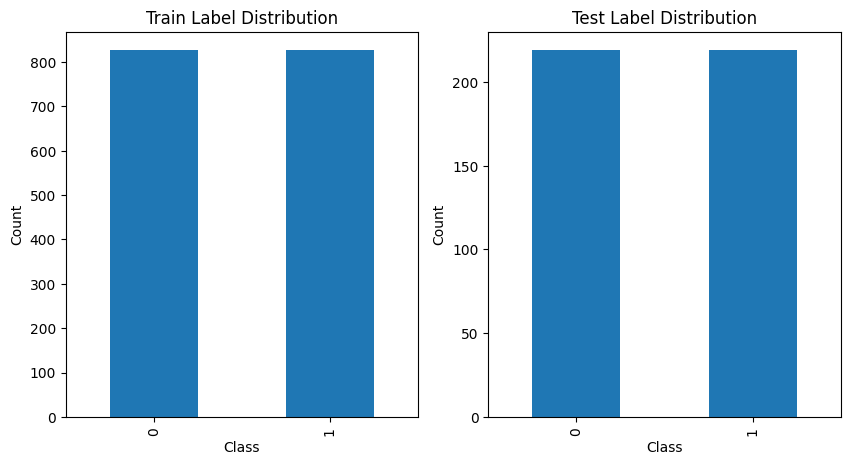

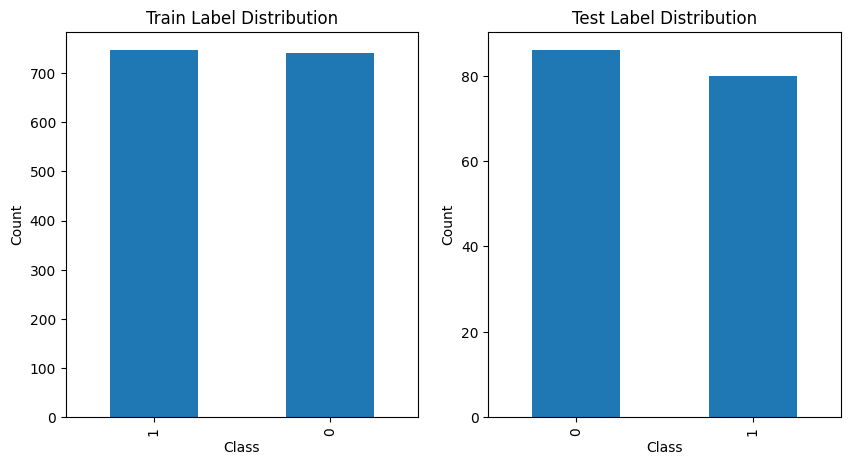

In [4]:
# Usage
df_train, df_test = train_test_split_and_balance(df, LABEL, TEST_SIZE, undersample=UNDERSAMPLE)
df_train, df_val = train_test_split_and_balance(df_train, LABEL, 0.1, undersample=False)

### Dataloaders

In [5]:
from torchvision import transforms

# Define the target image shape
SHAPE = (224, 224)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet statistics
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, saturation, and hue
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random affine transformation
])

In [6]:
# Create the custom dataset
train_dataset = CustomLabeledImageDataset(
    folder_path=IMAGES_PATH,
    dataframe=df_train,
    shape=SHAPE,
    transform=train_transforms,
    label_col=LABEL
)

test_dataset = CustomLabeledImageDataset(
    folder_path=IMAGES_PATH,
    dataframe=df_test,
    shape=SHAPE,
    transform=None,
    label_col=LABEL
)

val_dataset = CustomLabeledImageDataset(
    folder_path=IMAGES_PATH,
    dataframe=df_val,
    shape=SHAPE,
    transform=None,
    label_col=LABEL
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

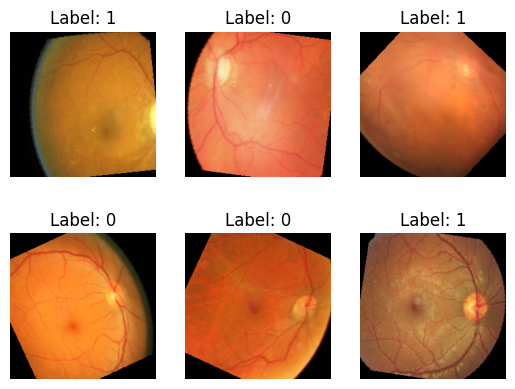

In [7]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels

for batch in train_dataloader:
    images, labels = batch

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [8]:
# Create a DataLoader to generate embeddings
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model

Using cache found in /home/datascience/.cache/torch/hub/facebookresearch_dinov2_main


FoundationalCVModelWithClassifier(
  (backbone): FoundationalCVModel(
    (backbone): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-11): 12 x NestedTensorBlock(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_fea

### Training:

In [9]:
# Define your hyperparameters
num_epochs = 25
learning_rate = 0.0001

# loss function and optimizer
criterion = nn.BCELoss()  #nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch 1, Training Loss: 0.7038300434748331
Epoch 1, Validation Loss: 0.7194135387738546
Epoch 2, Training Loss: 0.6977880845467249
Epoch 2, Validation Loss: 0.7371471325556437
Epoch 3, Training Loss: 0.6926780243714651
Epoch 3, Validation Loss: 0.6853890419006348
Epoch 4, Training Loss: 0.6832936728994051
Epoch 4, Validation Loss: 0.6652940909067789
Epoch 5, Training Loss: 0.6728417252500852
Epoch 5, Validation Loss: 0.6833050847053528
Epoch 6, Training Loss: 0.6670859778920809
Epoch 6, Validation Loss: 1.9775800704956055
Epoch 7, Training Loss: 0.6564116279284159
Epoch 7, Validation Loss: 0.7075885136922201
Epoch 8, Training Loss: 0.6545343299706777
Epoch 8, Validation Loss: 0.6569230357805887
Epoch 9, Training Loss: 0.6548402979969978
Epoch 9, Validation Loss: 0.7250114679336548
Epoch 10, Training Loss: 0.6479081784685453
Epoch 10, Validation Loss: 0.7176793615023295
Epoch 11, Training Loss: 0.6396688421567281
Epoch 11, Validation Loss: 12.183934529622396
Epoch 12, Training Loss: 0.7

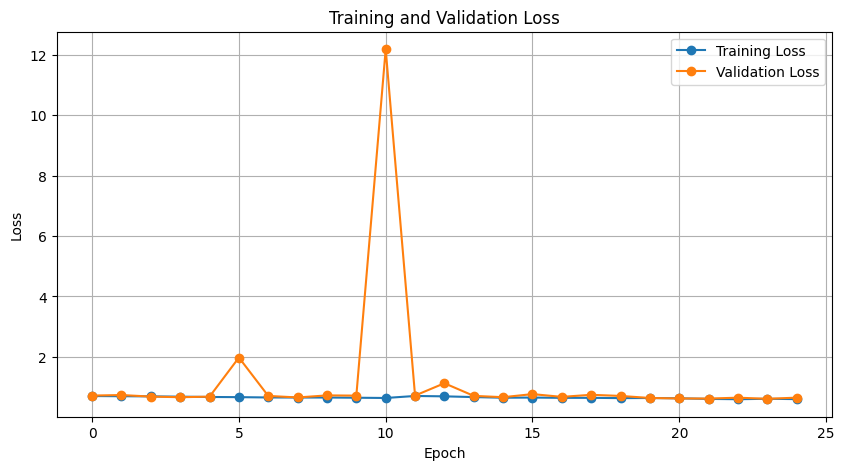

Training finished.


In [10]:
import torch
import matplotlib.pyplot as plt

# Initialize lists to store loss values
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_accuracy = 0.0
    num_train_batches = len(train_dataloader)

    # Training phase
    for inputs, labels in train_dataloader:
        # Calculate the outputs
        outputs = model(inputs)
        # Calculate loss
        loss = criterion(outputs, labels.float().unsqueeze(1)) # Ensure labels are tensors and have the right shape
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        # Update weights
        optimizer.step()
        
        # Calculate accuracy
        accuracy = (outputs.round() == labels).float().mean()
        total_accuracy += accuracy.item()
        total_loss += loss.item()

    avg_train_accuracy = total_accuracy / num_train_batches
    avg_train_loss = total_loss / num_train_batches

    print(f'Epoch {epoch + 1}, Training Loss: {avg_train_loss}')
    
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    num_val_batches = len(val_dataloader)

    with torch.no_grad():
        for val_inputs, val_labels in val_dataloader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels.float().unsqueeze(1)).item()
            val_accuracy += (val_outputs.round() == val_labels).float().mean().item()

    val_loss /= num_val_batches
    val_accuracy /= num_val_batches

    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss}')

    val_losses.append(val_loss)

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

print('Training finished.')

# Save the trained model if needed
torch.save(model.state_dict(), f'Models/fine_tuned_{BACKBONE}.pth')

### Test

In [11]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

model.eval()

# Initialize lists to store true labels and model predictions
true_labels = []
model_predictions = []

eval_images_0 = []
eval_images_1 = []

with torch.no_grad():
    for images, labels in test_dataloader:
        outputs = model(images)
        predicted = outputs.round()
        # _, predicted = torch.max(outputs.data, 1)
        # Collect true labels and model predictions
        true_labels += labels.tolist()
        model_predictions += predicted.tolist()
        
        if len(eval_images_0) < 5:
            # Collect evaluation images with class 0 and 1
            eval_images_0 += [img for i, img in enumerate(images) if labels[i] == 0]
        if len(eval_images_1) < 5:    
            eval_images_1 += [img for i, img in enumerate(images) if labels[i] == 1]

# Calculate accuracy, AUC, and F1 score
accuracy = accuracy_score(true_labels, model_predictions)
auc = roc_auc_score(true_labels, model_predictions)
f1 = f1_score(true_labels, model_predictions)

print(f'Accuracy on test images: {100 * accuracy}%')
print(f'AUC: {auc}')
print(f'F1 Score: {f1}')

Accuracy on test images: 68.94977168949772%
AUC: 0.6894977168949772
F1 Score: 0.7290836653386454


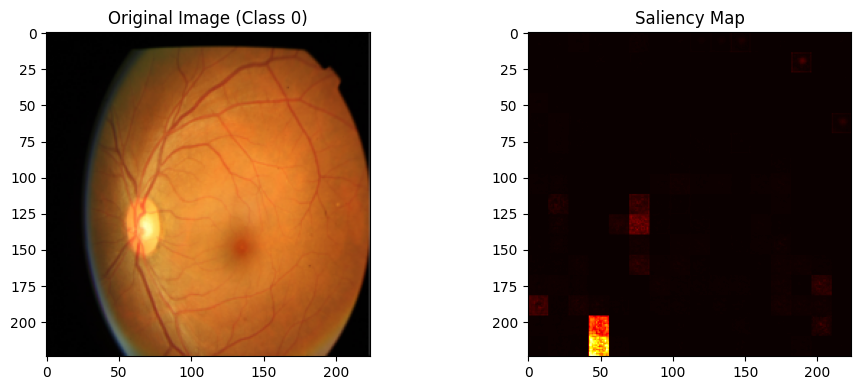

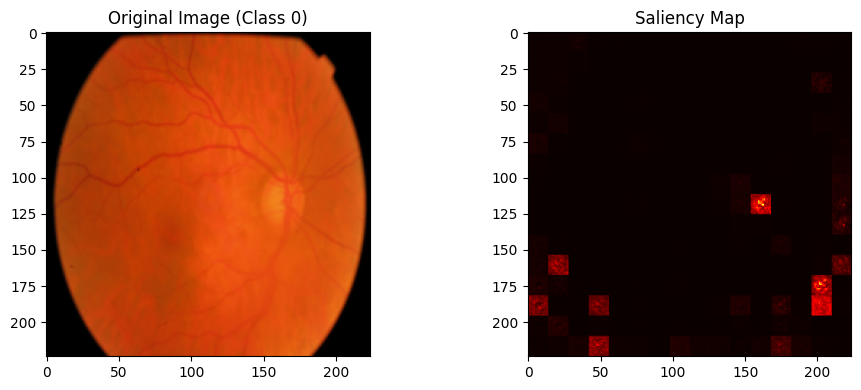

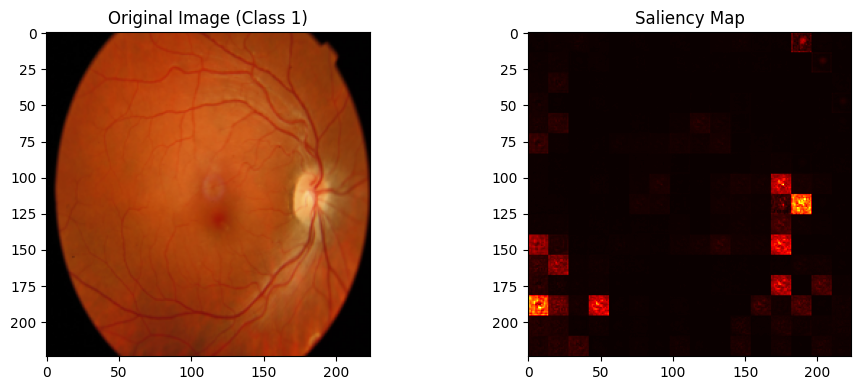

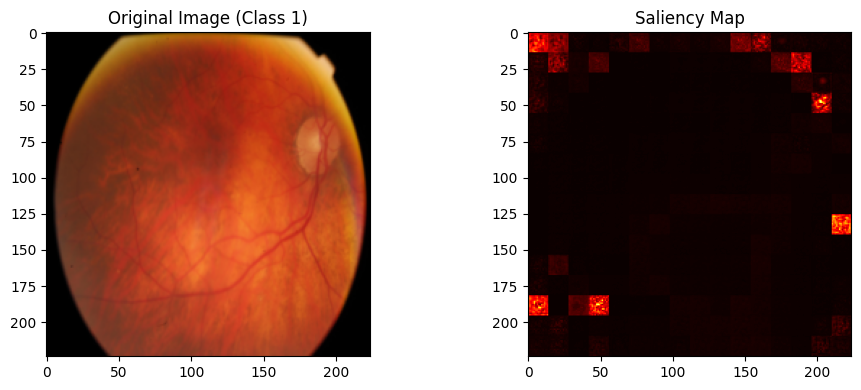

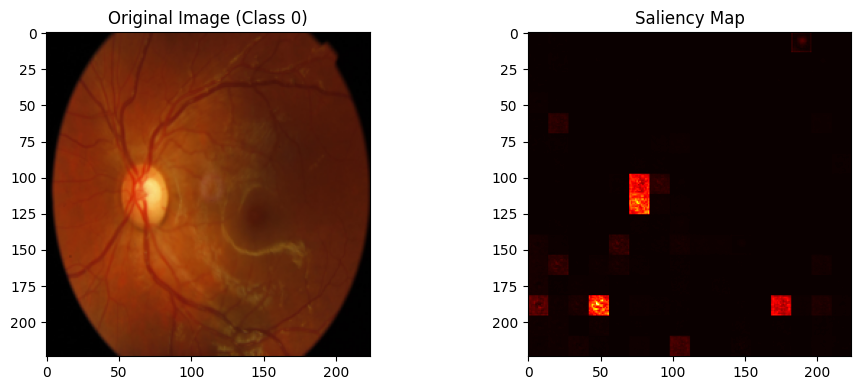

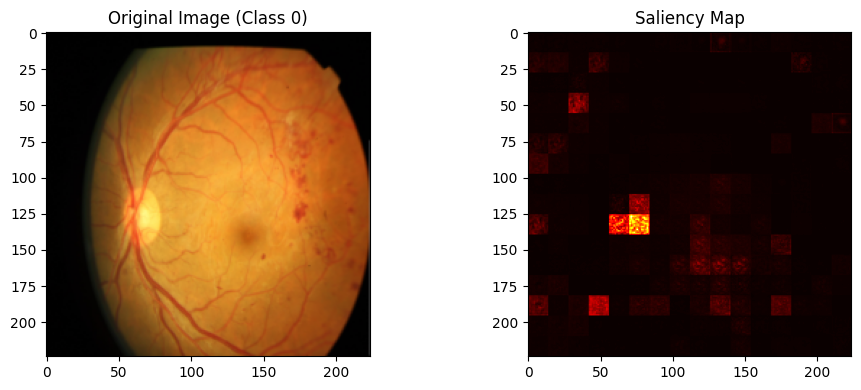

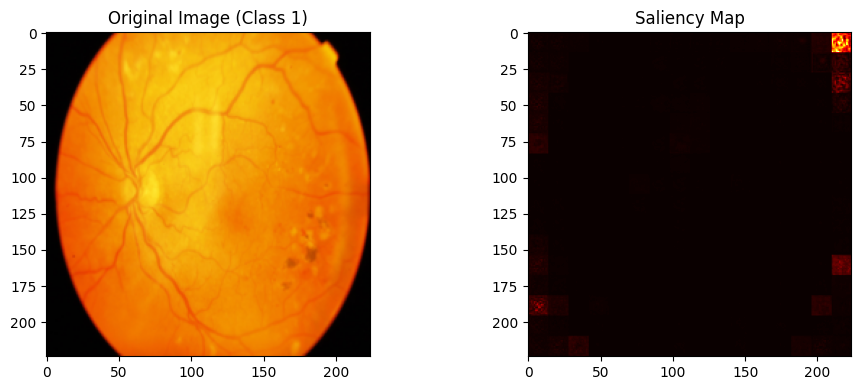

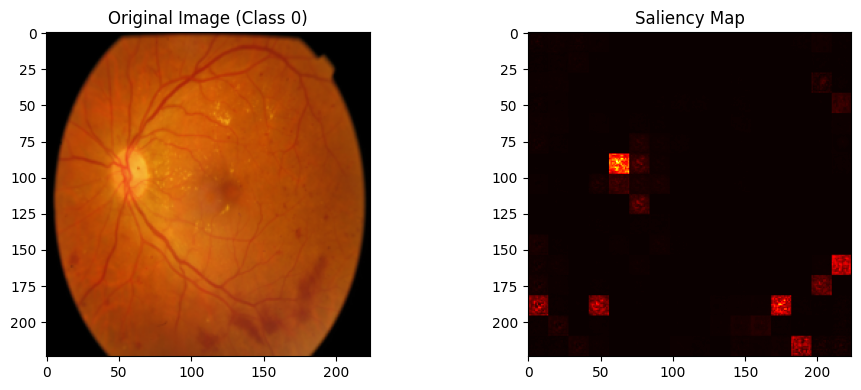

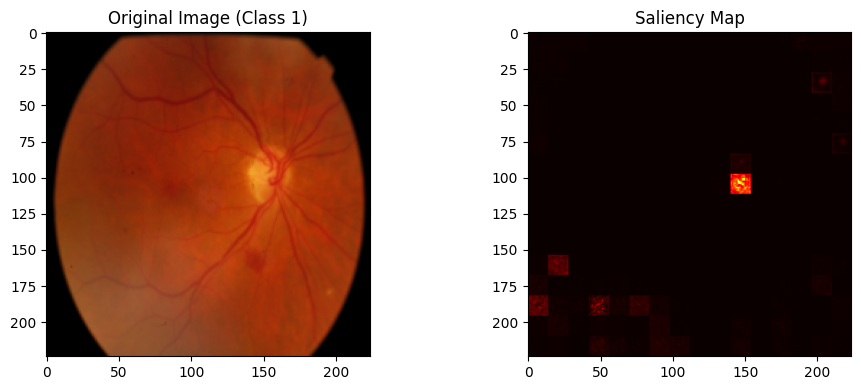

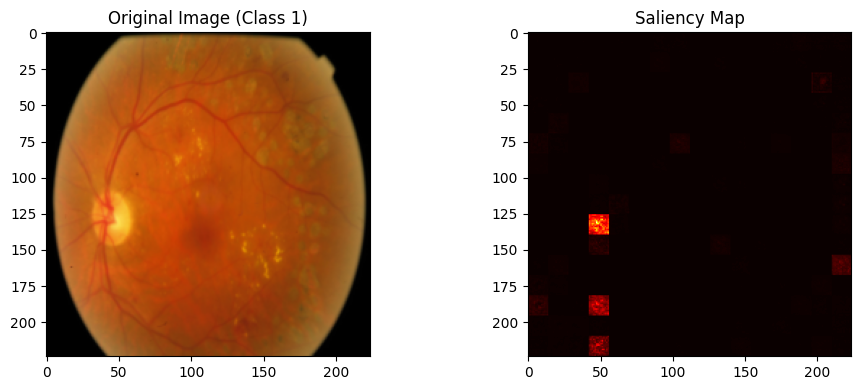

In [12]:
# Generate Saliency Maps
def get_saliency_map(model, input_image):
    model.eval()
    input_image.requires_grad_()
    output = model(input_image)
    max_idx = output.argmax()
    output[0, max_idx].backward()
    saliency_map, _ = torch.max(input_image.grad.data.abs(),dim=1)
    #saliency_map = input_image.grad.data.abs().max(1)[0]
    return saliency_map

# Select some evaluation images to generate saliency maps
eval_images = eval_images_0[:5] + eval_images_1[:5]

#print(eval_images)

for i, eval_image in enumerate(eval_images):
    eval_image = eval_image.unsqueeze(0)  # Add batch dimension
    saliency_map = get_saliency_map(model, eval_image)

    # Plot original image and saliency map side by side
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(eval_image[0].permute(1, 2, 0).detach().numpy())
    plt.title(f'Original Image (Class {labels[i]})')
    
    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map[0].detach().numpy(), cmap=plt.cm.hot)
    plt.title('Saliency Map')
    
    plt.tight_layout()
    plt.show()